The file does two tasks:
1) Runs over the NanoAOD files using coffea and the processor in `CoffeaJERCProcessor_L5.py`, and creates the histograms of jet reponses and reco jet $p_T$. Stores the result in outname='out/CoffeaJERCOutputs'tag_Lx+'_'+data_tag+add_tag'.coffea'
2) Fits the response histograms (or calculates the medians) and creates the `txt` files with the fit results (one fle for each `Mean`, `MeanVar`, `Median`, `MedianStd`, `MeanRecoPt`)

It is possible to bypass the (usually long) part 1) by applying `load_preexisting = True`. In such case, a file with `outname` will be read and then the histograms refit.
Options for running on condor, coffea Case using dask are available. See, under `Parameters of the run and switches`.

At the moment, for producing the flavor uncertatinties, for obtaining the results over the 6 datasets neccessary, the script has to be once for each of them (QCD stiching is done automatically) as dask+condor is still sometimes unstable, but this can be united in the future.

# Dask Setup:
---
### For Dask+Condor setup on lxplus
#### 1.) The wrapper needs to be installed following https://github.com/cernops/dask-lxplus
#### 2.) Source lcg environment in bash
#### `source /cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/latest/x86_64-centos7-gcc11-opt/setup.sh`
#### Singularity could work but not confirmed.
---
### For Coffea-Casa, the client must be specified according to the user that is logged into the Coffea-Casa Environment.
#### 1.) go to the left of this coffea-casa session to the task bar and click the orange-red button; it will say "Dask" if you hover your cursor over it
#### 2.) scroll down to the blue box where it shows the "Scheduler Address"
#### 3.) write that full address into the dask Client function 
#### Example: `client = Client("tls://ac-2emalik-2ewilliams-40cern-2ech.dask.coffea.casa:8786")`
---
### For CMSLPC, the client must be specified with the LPCCondorCluster
#### 1.) follow installation instructions from https://github.com/CoffeaTeam/lpcjobqueue, if you have not already done so, to get a working singularity environment with access to lpcjobqueue and LPCCondorCluster class
#### 2.) import LPCCondorCluster: `from lpcjobqueue import LPCCondorCluster`
#### 3.) define the client
#### Example: 
`cluster = LPCCondorCluster()`

`client = Client(cluster)`


### My favorite notebook settings

In [16]:
## Print not only the last line in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%load_ext autoreload
## Set extension to reload modules every time before executing code
%autoreload 2  #0 to turn of reloading (though this does not work for me :()

## Don't autoclose brackets
from notebook.services.config import ConfigManager
c = ConfigManager()
c.update('notebook', {"CodeCell": {"cm_config": {"autoCloseBrackets": False}}})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


{'Cell': {'cm_config': {'lineNumbers': True}},
 'CodeCell': {'cm_config': {'autoCloseBrackets': False}},
 'load_extensions': {'jupyter-js-widgets/extension': True}}

### Imports

#### Import updated coffea and awkward versions

In [17]:
import sys
coffea_path = '/afs/cern.ch/user/a/anpotreb/top/JERC/coffea/'
if coffea_path not in sys.path:
    sys.path.insert(0,coffea_path)

ak_path = '/afs/cern.ch/user/a/anpotreb/top/JERC/local-packages/'

if ak_path not in sys.path:
    sys.path.insert(0,ak_path)

In [18]:
import time
import scipy.stats as ss
from coffea import processor, util
from coffea.nanoevents import NanoAODSchema, BaseSchema

import numpy as np
from numpy.random import RandomState
import importlib

# import inspect
import matplotlib.pyplot as plt
import matplotlib as mpl
import hist

from plotters.pltStyle import pltStyle
# pltStyle(style='hep')

# pltStyle(style='paper')
plt.rcParams['figure.dpi'] = 150
import os

### import subpackages
from helpers import hist_add, hist_mult, hist_div, dictionary_pattern, sum_subhist, xsecstr2float
from helpers import save_data, read_data, get_median, gauss, slice_histogram, add_flavors, fit_response
from plotters.plotters import plot_response_dist, plot_corrections, plot_corrections_eta, plot_response_dist_stack

from helpers import rebin_hist, mirror_eta_to_plus, sum_neg_pos_eta, find_ttbar_xsec
from common_binning import JERC_Constants
pltStyle(style='hep')
# %matplotlib notebook 

### Parameters of the run and switches

In [19]:
UsingDaskExecutor = False   ### True if use dask local executor, otherwise use futures
CERNCondorCluster = False   ### True if run on the CERN condor cluster using dask. Requires `UsingDaskExecutor` = True
CoffeaCasaEnv     = False   ### True if run on coffea case. Never tested since ages.
load_preexisting  = True    ### True if don't repeat the processing of files and use preexisting JER from output
test_run          = False   ### True if run only on one file and five chuncs to debug processor
load_fit_res      = False   ### True if only replot the fit results

### Choose eta binning for the response fits.
### HCalPart: bin in HCal sectors, CaloTowers: the standard JERC binning,
### CoarseCalo: like 'CaloTowers' but many bins united; onebin: combine all eta bins
### Preprocessing always done in CaloTowers
eta_binning  = "HCalPart"  ### HCalPart, CoarseCalo, JERC, CaloTowers, Summer20Flavor, onebin;
sum_neg_pos_eta_bool=True  ### if combining the positive and negative eta bins

Nfiles = -1                 ### -1 for all files

tag_Lx = '_L5'                 ### L5 or L23, but L23 not supported since ages.

### Define the dataset either by using a `data_tag` available in `dataset_dictionary`
### Or manualy by defining `dataset` (below) with the path to the .txt file with the file names (without the redirectors).
### Or manually by defining `fileslist` as the list with file names.
### data_tag will be used to name output figures and histograms.
data_tag = 'QCD-Py' # 'QCD-MG-Her' #'Herwig-TTBAR' 
# data_tag = 'DY-FxFx'
### name of the specific run if parameters changed used for saving figures and output histograms.
add_tag = '' #'_3rd_jet' # _cutpromtreco _Aut18binning   
run_comment = ''                          #### Comment for the log file: e.g., why the run is made?

certificate_dir = '/afs/cern.ch/user/a/anpotreb/k5-ca-proxy.pem'

# fileslist = ['root://xrootd-cms.infn.it/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/2510000/056516']

In [20]:
processor_config = {
    # cut: {cut_parameters}
    "good_lepton_cut":      {"apply":True},
    "tight_lepton_veto_id": {"apply":True},
    "recolep_drcut": {"apply":True},
    "jet_pt_cut": {
        "apply":True,
        "mingenjetpt": 15,
    },
    "leading_jet_and_alpha_cut":{
        "apply":True,
        "alphaQCD": 1.0,
        "alphaDY":  1.0,
        "NjetsQCD": 3,
        "NjetsDY":  2,
    },
    "select_Nth_jet":{
        "apply":True,
        "N": 2,
    },
    "jet_iso_cut":{"apply":False},
    ### Choose the jet flavour. Some samples have missing `partonFlavour`, so one has to redo the flavour matching oneself. Two different option were implemented:
    ### `LHE_flavour` starts from the jet and matches to the closest LHE particle.
    ### `LHE_flavour2` (a better option) starts from the LHE particle and matches to the jet 
    "jetflavour":'partonFlavour'
    # ... Add more cuts and parameters as needed
}

### Dataset parameters

In [21]:
from fileNames.available_datasets import dataset_dictionary

dataset = None
fileslist = None

printout = ''  ### to be used in the saved output to .txt
tag_full = tag_Lx+'_'+data_tag+add_tag
if not (fileslist is None):
    xsec = 1
    legend_label = data_tag
    printout += f'A specific fileslist specified. The calculation will be run on the files {fileslist}. The histograms will be saved with the provided tag {data_tag} \n'
elif data_tag in dataset_dictionary.keys():
    dataset, xsec, legend_label = dataset_dictionary[data_tag]
    if dataset is None:
        printout += (f'The data tag "{data_tag}" found in the dataset_dictionary. The dataset with the path to cross-sections {xsec} will be used. \n')
    else:
        printout += f'The data tag "{data_tag}" found in the dataset_dictionary. The dataset with the path to file names "{dataset}" will be used. \n'
elif not(dataset is None):
    xsec = 1
    legend_label = data_tag
    printout += (f'Using the provided dataset with the path to file names {dataset[0]} and the provided data tag "{data_tag}". \n')
else:
    raise ValueError(f'The data tag "{data_tag}" not found in the dataset_dictionary and no dataset provided.')
    
print(printout)

The data tag "QCD-Py" found in the dataset_dictionary. The dataset with the path to file names "fileNames/QCD20UL18_JMENano.txt" will be used. 



In [22]:
### Choose the correct redirector
## assume running on the LPC
# xrootdstr = 'root://cmsxrootd.fnal.gov/'
## assume running on the lxplus
# xrootdstr = 'root://cms-xrd-global.cern.ch//'
xrootdstr = 'root://xrootd-cms.infn.it/'

# if running on coffea casa instead...
if CoffeaCasaEnv:
    xrootdstr = 'root://xcache/'

### Do some logic with the input partameters and the rest of parameters of the run

In [23]:
#Import the correct processor
Processor = importlib.import_module('CoffeaJERCProcessor'+tag_Lx).Processor
# Processor = importlib.import_module('GetAlphaDristributionProcessor').Processor

tag_full = tag_Lx+'_'+data_tag+add_tag
if test_run:
    tag_full = tag_full+'_test'
outname = 'out/CoffeaJERCOutputs'+tag_full+'.coffea'

tag_fit_res = tag_full

if eta_binning != "HCalPart":
    tag_fit_res=tag_full+'_'+eta_binning
    
if load_preexisting == True:
    UsingDaskExecutor = False
    
if UsingDaskExecutor == False:
    CERNCondorCluster = False
    
if not os.path.exists("out"):
    os.mkdir("out")
        
if not os.path.exists("fig"):
    os.mkdir("fig/")
    os.mkdir("fig/responses/")
    
if test_run and not os.path.exists("test"):
    os.mkdir("test/")
    os.mkdir("test/fig")
    
out_txt_path = "out_txt" if not test_run else "test/out_txt"
if not os.path.exists(out_txt_path):
    os.mkdir(out_txt_path)
    
maxchunks = 5 if test_run else None
if test_run:
    Nfiles = 1

printout_tmp = f'Running on the number of files: {Nfiles}\n Job with the full tag {tag_full}\n Outname = {outname}'
print(printout_tmp)
printout += printout_tmp


Running on the number of files: -1
 Job with the full tag _L5_QCD-Py
 Outname = out/CoffeaJERCOutputs_L5_QCD-Py.coffea


### For the attempt to correctly combine three ttbar channels. Not fully tested

In [24]:
from helpers import get_xsecs_filelist_from_file

def txt2filesls(dataset_name):
    with open(dataset_name) as f:
        rootfiles = f.read().split()
        fileslist = [xrootdstr + file for file in rootfiles]
    return fileslist

if fileslist is not None:
    xsec_dict = {data_tag: xsec}
    filesets = {data_tag: {"files": fileslist, "metadata": {"xsec": xsec}}}
elif (dataset is None) and (xsec is not None):
    ### if dataset striched together from a set of datasets where the cross-section for each is given in `xsec`
    xsec_dict, file_dict = get_xsecs_filelist_from_file(xsec, data_tag, test_run)
    path_to_xsec = '/'.join(xsec.split('/')[:-1])
    filesets = {}
    for key in file_dict.keys():
        data_name = file_dict[key]
        fileslist = txt2filesls(path_to_xsec+'/'+data_name)[:Nfiles]
        filesets[key] = {"files": fileslist, "metadata": {"xsec": xsec_dict[key]}}
else:
    fileslist = txt2filesls(dataset)[:Nfiles]
    #### If manyally adding fileslist
    xsec_dict = {data_tag: xsec}
    filesets = {data_tag: {"files": fileslist, "metadata": {"xsec": xsec}}}


Test if certificate works to open the file

In [25]:
### RUN THIS CELL ONLY IF YOU ARE USING SWAN 

##### REMEMBER TO MANUALLY COPY THE PROXY TO YOUR CERNBOX FOLDER AND TO MODIFY THE NEXT LINE
os.environ['X509_USER_PROXY'] = certificate_dir
if os.path.isfile(os.environ['X509_USER_PROXY']):
    print("Found proxy at {}".format(os.environ['X509_USER_PROXY']))
else:
    print("os.environ['X509_USER_PROXY'] ",os.environ['X509_USER_PROXY'])
os.environ['X509_CERT_DIR'] = '/cvmfs/cms.cern.ch/grid/etc/grid-security/certificates'
os.environ['X509_VOMS_DIR'] = '/cvmfs/cms.cern.ch/grid/etc/grid-security/vomsdir'
os.environ['X509_USER_CERT'] = '/afs/cern.ch/user/a/anpotreb/k5-ca-proxy.pem'

env_extra = [
            f'export X509_USER_PROXY={certificate_dir}',
            f'export X509_CERT_DIR={certificate_dir}',
        ]

Found proxy at /afs/cern.ch/user/a/anpotreb/k5-ca-proxy.pem


In [26]:
if not load_preexisting:
    import uproot
    ff = uproot.open(fileslist[0])
    ff.keys()
    ff.close()

    # print(f"The test file read successfully. All good with certifiates.")

In [27]:
 # Dask set up for Coffea-Casa only
if(UsingDaskExecutor and CoffeaCasaEnv):
    from dask.distributed import Client 
    client = Client("tls://ac-2emalik-2ewilliams-40cern-2ech.dask.coffea.casa:8786")
    client.upload_file('CoffeaJERCProcessor.py')

In [28]:
if(UsingDaskExecutor and not CoffeaCasaEnv):
    from dask.distributed import Client 
 # Dask set up for LPC only 
    if not CERNCondorCluster:
        client = Client()
        client.get_versions(check=True)
#         client.nanny = False

    else:
        from dask_lxplus import CernCluster
        import socket

        cluster = CernCluster(
# #             memory=config.run_options['mem_per_worker'],
# #             disk=config.run_options.get('disk_per_worker', "20GB"),
#             env_extra=env_extra,
            cores = 1,
            memory = '4000MB',
            disk = '2000MB',
            death_timeout = '60',
            lcg = True,
            nanny = False,
            container_runtime = 'none',
            log_directory = '/eos/user/a/anpotreb/condor/log',
            scheduler_options = {
                'port': 8786,
                'host': socket.gethostname(),
            },
            job_extra = {
                'MY.JobFlavour': '"longlunch"',
#                 'transfer_input_files': '/afs/cern.ch/user/a/anpotreb/top/JERC/JMECoffea/count_2d.py',
            },
        )
        cluster.adapt(minimum=2, maximum=200)
        cluster.scale(8)
        client = Client(cluster)
    
    client.upload_file('CoffeaJERCProcessor'+tag_Lx+'.py')
    client.upload_file('GetAlphaDristributionProcessor.py')
    client.upload_file('LHE_flavour.py')
    client.upload_file('common_binning.py')
    client.upload_file('JERCProcessorcuts.py')

    client

### Run the processor

In [29]:
# outname = 'out/no_?lep_cuts/CoffeaJERCOutputs_L5_QCD-Py.coffea'

In [30]:
tstart = time.time()

outputs_unweighted = {}

seed = 1234577890
prng = RandomState(seed)
chunksize = 10000
# maxchunks = 100

if not load_preexisting:
    if not UsingDaskExecutor:
        chosen_exec = 'futures'
        output = processor.run_uproot_job(filesets,
                                          treename='Events',
                                          processor_instance=Processor(processor_config),
                                          executor=processor.iterative_executor,
    #                                        executor=processor.futures_executor,
                                          executor_args={
                                              'skipbadfiles':True,
                                              'schema': NanoAODSchema, #BaseSchema
                                              'workers': 2},
                                          chunksize=chunksize,
                                          maxchunks=maxchunks)
    else:
        chosen_exec = 'dask'
        output = processor.run_uproot_job(filesets,
                                          treename='Events',
                                          processor_instance=Processor(processor_config),
                                          executor=processor.dask_executor,
                                          executor_args={
                                              'client': client,
                                              'skipbadfiles':True,
                                              'schema': NanoAODSchema, #BaseSchema
                                              'xrootdtimeout': 60,
                                              'retries': 2,
#                                               'workers': 2
                                          },
                                          chunksize=chunksize,
                                          maxchunks=maxchunks)

    elapsed = time.time() - tstart
    print("Processor finished. Time elapsed: ", elapsed)
#     outputs_unweighted[name] = output
    print("Saving the output histograms under: ", outname)
    util.save(output, outname)
#     outputs_unweighted[name] = output
else:
    output = util.load(outname)
    print("Loaded histograms from: ", outname)

#### Attempt to prevent the error when the cluster closes. Doesn't always work.
if UsingDaskExecutor:
    client.close()
    time.sleep(5)
    if CERNCondorCluster or CoffeaCasaEnv:
        cluster.close()

Loaded histograms from:  out/CoffeaJERCOutputs_L5_QCD-Py.coffea


In [31]:
# output_QCD_Py = util.load("out/CoffeaJERCOutputs_L5_QCD-Py.coffea")
# output_QCD_Py_3leadingjets_noiso = util.load("out/CoffeaJERCOutputs_L5_QCD-Py_3leadingjets_noiso.coffea")
# output_QCD_Py_2leadingjets_iso = util.load("out/CoffeaJERCOutputs_L5_QCD-Py2leadingjets.coffea")
# # output_QCD_Py_new = util.load("out/CoffeaJERCOutputs_L5_QCD-Py.coffea")
# output_Pythia_TTBAR = util.load("out/CoffeaJERCOutputs_L5_Pythia-TTBAR.coffea")
# output_Pythia_TTBAR_iso_cut = util.load("out/CoffeaJERCOutputs_L5_Pythia-TTBAR_iso_cut.coffea")
# # output_Pythia_TTBAR_new = util.load("out/CoffeaJERCOutputs_L5_Pythia-TTBAR.coffea")
# output_DY_MG_Py_allrecolep = util.load("out/CoffeaJERCOutputs_L5_DY-MG-Py_nolepsel_cutallrecolep.coffea")
# output_Pythia_TTBAR_allrecolep = util.load("out/CoffeaJERCOutputs_L5_Pythia-TTBAR_nolepsel_cutallrecolep.coffea")
# # output_Pythia_TTBAR_allrecolep = util.load("out/CoffeaJERCOutputs_L5_Pythia-TTBAR_nolepsel_cutallrecolep.coffea")
# # output_Pythia_TTBAR_wronglep = util.load("out/CoffeaJERCOutputs_L5_Pythia-TTBAR_nolepsel_wronglepcut.coffea")

In [32]:
# output_Pythia_TTBAR['Pythia-TTBAR']['cutflow'][[ 'all_jets', 'gen_matched', 'jets, tight lepton id', 'jets, dR cut with leptons', 'jetpt>15', 'alpha cut; leading jets', 'iso jets']]
# output_Pythia_TTBAR_iso_cut['Pythia-TTBAR']['cutflow'][[ 'all_jets', 'gen_matched', 'jets, tight lepton id', 'jets, dR cut with leptons', 'jetpt cut', 'alpha cut; leading jets', 'iso jets']]

In [33]:
# output_QCD_Py_3leadingjets_noiso['QCD-Py']['cutflow']

In [34]:
# output_QCD_Py_3leadingjets_noiso['QCD-Py']['cutflow'][['all_jets', 'gen_matched', 'jets, tight lepton id', 'jets, dR cut with leptons', 'jetpt cut', 'alpha cut; leading jets', 'iso jets' ]].values()
# output_QCD_Py_2leadingjets_iso['QCD-Py']['cutflow'][['all_jets', 'gen_matched', 'jets, tight lepton id', 'jets, dR cut with leptons', 'jetpt>15', 'alpha cut; leading jets', 'iso jets' ]].values()

In [35]:
# output_QCD_Py_new['QCD-Py']['cutflow'][['all_jets', 'gen_matched', 'jets, tight lepton id', 'jets, dR cut with leptons', 'jetpt>15', 'alpha cut; leading jets', 'iso jets' ]].values()

In [36]:
# output_QCD_Py_new['QCD-Py']['cutflow'][['all_jets', 'gen_matched', 'jets, tight lepton id', 'jets, dR cut with leptons', 'jetpt>15', 'alpha cut; leading jets', 'iso jets' ]] #.plot1d()
# output_QCD_Py['dataset1']['cutflow']
# output_Pythia_TTBAR_new['Pythia-TTBAR']['cutflow'][['all_jets', 'gen_matched', 'jets, tight lepton id', 'jets, dR cut with leptons', 'jetpt>15', 'alpha cut; leading jets', 'iso jets' ]]
# output_Pythia_TTBAR['dataset1']['cutflow']
# output_QCD_Py_wronglep['QCD-Py']['cutflow']
# output_Pythia_TTBAR_wronglep['Pythia-TTBAR']['cutflow']

### Striching up the sample

In [37]:
# output_orig = output
# if len(xsec_dict)>1:
#     keys = ['QCD-MG-Py_HT50to100', 'QCD-MG-Py_HT100to200', 'QCD-MG-Py_HT200to300', 'QCD-MG-Py_HT300to500',
#             'QCD-MG-Py_HT500to700', 'QCD-MG-Py_HT700to1000', 'QCD-MG-Py_HT1000to1500', 'QCD-MG-Py_HT1500to2000', 'QCD-MG-Py_HT2000toInf']
#     keys = ['QCD-MG-Her_HT50to100', 'QCD-MG-Her_HT100to200', 'QCD-MG-Her_HT200to300', 'QCD-MG-Her_HT300to500',
#             'QCD-MG-Her_HT500to700', 'QCD-MG-Her_HT700to1000', 'QCD-MG-Her_HT1000to1500', 'QCD-MG-Her_HT1500to2000', 'QCD-MG-Her_HT2000toInf']

keys = output.keys()
Nev = {key: output[key]['cutflow']['all_events'].value for key in keys}
# response_sums = {key:sum(dictionary_pattern(output[key], "ptresponse_").values()).sum().value for key in output.keys()}
# scale_factors = {key:1 for key in output.keys()} #hist_div(xsec_dict, Nev)
scale_factors = hist_div(xsec_dict, Nev)
#     scale_factors['QCD-MG-Py_HT50to100'] = 0
all_histo_keys = output[next(iter(output.keys()))].keys()
hists_merged = {histo_key:sum_subhist(output, histo_key, scale_factors) for histo_key in all_histo_keys }
# # output = result
# elif len(output.keys())==1:
output = output[list(output.keys())[0]]

### Fit responses

Define some global variables for the fit

In [38]:
from JetEtaBins import JetEtaBins, PtBins

jeteta_bins = JetEtaBins(eta_binning)
pt_bins = PtBins("MC_truth")
fiteta_bins = JetEtaBins(eta_binning, absolute=True) if sum_neg_pos_eta_bool else jeteta_bins

In [39]:
import warnings
# warnings.filterwarnings('ignore') ### To suppress warnings with bad

def fit_responses(hists, flavor='b', saveplots = None, scaled_hist=None):
    ''' Extract the jet flavor `flavor` from the histogram dictionary `hists` and fit in all the eta and pt bins.
    Add `scaled_hist` if to produce the response distributions with all the samples stacked up.
    Return a dictionary of ["Mean", "MeanVar", "Median", "MedianStd", "MeanRecoPt"] values.
    
    '''
    warnings.filterwarnings('ignore')  ### filter out the many fit warnings
    if saveplots==None:
        saveplots = False if test_run or eta_binning != "HCalPart" else True
        
    response_hists = {}
    recopt_hists = {}
    if not scaled_hist==None:
        for sample in scaled_hist:
            response_hist, recopt_hist = add_flavors(scaled_hist[sample], flavor, combine_antiflavour) 
            response_hist = rebin_hist(response_hist, 'jeteta' , jeteta_bins.edges)
            recopt_hist = rebin_hist(recopt_hist, 'jeteta' , jeteta_bins.edges)
            if sum_neg_pos_eta_bool==True:
                response_hist = sum_neg_pos_eta(response_hist)
                recopt_hist = sum_neg_pos_eta(recopt_hist)
            response_hists[sample] = response_hist
            recopt_hists[sample] = recopt_hist
        
    response_hist, recopt_hist = add_flavors(hists, flavor, combine_antiflavour)
    
    response_hist = rebin_hist(response_hist, 'jeteta' , jeteta_bins.edges)
    recopt_hist = rebin_hist(recopt_hist, 'jeteta' , jeteta_bins.edges)
    
    if sum_neg_pos_eta_bool==True:
        response_hist = sum_neg_pos_eta(response_hist)
        recopt_hist = sum_neg_pos_eta(recopt_hist)
        
    results = {key:np.zeros((pt_bins.nbins, fiteta_bins.nbins))
                  for key in ["Mean", "MeanVar", "Median", "MedianStd", "MeanRecoPt"]  }
                            
    N_converge = 0
    N_not_converge = 0

    FitFigDir1 = 'fig/responses/responses'+tag_full
    if saveplots and not os.path.exists(FitFigDir1):
        os.mkdir(FitFigDir1)
    
    FitFigDir = FitFigDir1+'/response_pt_eta_'+flavor+tag_full
    if saveplots:
        if not os.path.exists(FitFigDir):
            os.mkdir(FitFigDir)
        print("Response fits will be saved under ", FitFigDir)
    elif not saveplots:
        print("Response fits won't be saved")

    for i in range(pt_bins.nbins):
#     for i in range(4,10):
        for k in range(fiteta_bins.nbins):
            if not scaled_hist==None:
                histos = {sample: response_hists[sample][i, :, k] for sample in response_hists}
                histos2plot = {key[10:]:histos[key] for key in histos.keys()}
                h_stack = hist.Stack.from_dict(histos2plot)
            
            histo = response_hist[i, :, k]
            histopt = recopt_hist[i, k]            
            try:
                Neff = histo.sum().value**2/(histo.sum().variance)
            except ZeroDivisionError:
                Neff = histo.sum().value**2/(histo.sum().variance+1e-20)

            median, medianstd = get_median(histo, Neff)
            
            ##################### Mean of the pt_reco  ######################
            ### (The mean includes events that potentially had ptresponse in the second peak at low pt)
            ### No way to distinguish it if only x*weights are saved instead of the whole histogram.
            mean_reco_pt = histopt.value/np.sum(histo.values())
            
            ####################### Fitting ############################
            p2, cov, chi2, Ndof, if_failed, fitlims = fit_response(histo, Neff, Nfit=3, sigma_fit_window=1.5)
            if if_failed:
                N_not_converge += 1
            else:
                N_converge += 1
            
            ####################### Store the results ############################
            results["Mean"][i,k] = p2[1]
            results["MeanVar"][i,k] = cov[1,1]
            results["Median"][i,k] = median
            results["MedianStd"][i,k] = medianstd
            results["MeanRecoPt"][i,k] = mean_reco_pt

    ####################### Plotting ############################
            if  saveplots:
                figName = FitFigDir+'/ptResponse'+pt_bins.idx2str(i)+fiteta_bins.idx2str(k)
                hep_txt = pt_bins.idx2plot_str(i)+'\n'+fiteta_bins.idx2plot_str(k)+'\n'+f'{flav} jet' 
        
                txt2print = ('\n'+r'Mean = {0:0.3f}$\pm${1:0.3f}'.format(p2[1], np.sqrt(cov[1,1]))
                                 + '\nWidth = {0:0.3f}$\pm${1:0.3f}'.format(np.abs(p2[2]), np.sqrt(cov[2,2]))
                                 + '\n'+r'Median = {0:0.3f}$\pm${1:0.3f}'.format(median, medianstd)
                                 + '\n'+r'$\chi^2/ndof$ = {0:0.2g}/{1:0.0f}'.format(chi2, Ndof)
                                 + '\n'+r'Neff = {0:0.3g}'.format(Neff))
                plot_response_dist(histo, p2, fitlims,
                                   figName, dataset_name=legend_label, hep_txt=hep_txt, txt2print=txt2print, print_txt=True)              
                if not scaled_hist==None:
                    plot_response_dist_stack(h_stack, p2, fitlims,
                                             figName+'stack', hep_txt=hep_txt, print_txt=False )

    print("N converge = ", N_converge, "N_not_converge = ", N_not_converge );
    warnings.filterwarnings('default')
    
    return results  

### Run fitting for each sample

In [40]:
out_txt_path = "out_txt" #/no_lep_cuts/"

In [41]:
pltStyle(style='hep')
plt.rcParams['font.size'] = plt.rcParams['font.size']/0.98

-------------------------
-------------------------
Starting to fit each flavor in: ['b', 'ud', 'all', 'g', 'c', 's', 'q', 'u', 'd', 'unmatched']
-------------------------
-------------------------
Fitting flavor:  b
Response fits won't be saved
N converge =  82 N_not_converge =  30
Figure saved: fig/corr_vs_pt/QCD-Py/corr_vs_pt_QCD-Py_b.pdf /.png


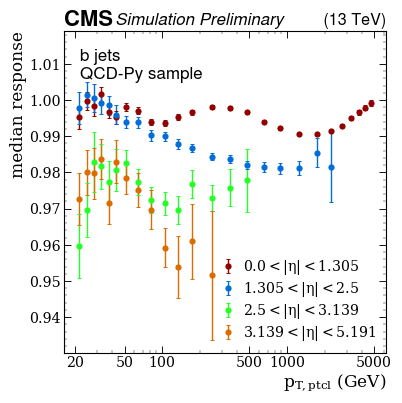

-------------------------
-------------------------
Fitting flavor:  ud
Response fits won't be saved
N converge =  86 N_not_converge =  26
Figure saved: fig/corr_vs_pt/QCD-Py/corr_vs_pt_QCD-Py_ud.pdf /.png


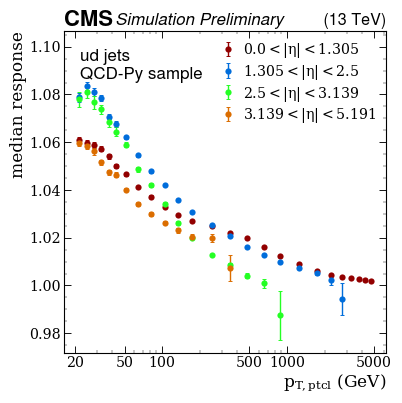

-------------------------
-------------------------
Fitting flavor:  all
Response fits won't be saved
N converge =  87 N_not_converge =  25
Figure saved: fig/corr_vs_pt/QCD-Py/corr_vs_pt_QCD-Py_all.pdf /.png


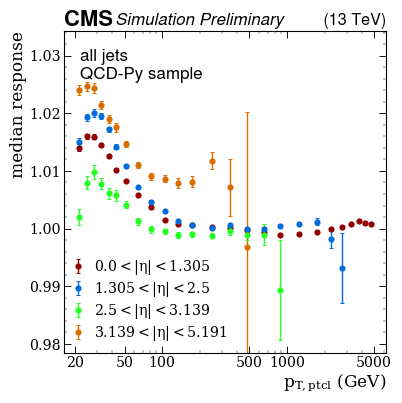

-------------------------
-------------------------
Fitting flavor:  g
Response fits won't be saved
N converge =  83 N_not_converge =  29
Figure saved: fig/corr_vs_pt/QCD-Py/corr_vs_pt_QCD-Py_g.pdf /.png


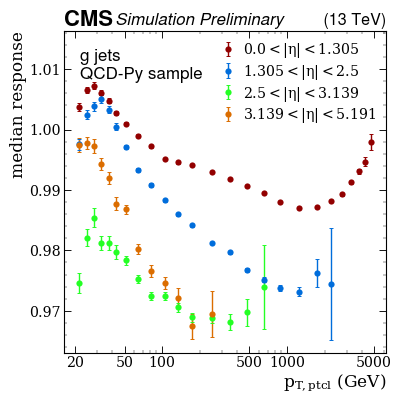

-------------------------
-------------------------
Fitting flavor:  c
Response fits won't be saved
N converge =  83 N_not_converge =  29
Figure saved: fig/corr_vs_pt/QCD-Py/corr_vs_pt_QCD-Py_c.pdf /.png


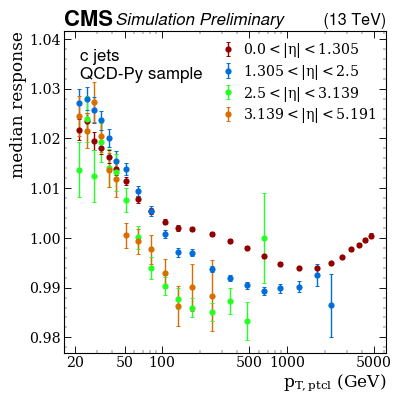

-------------------------
-------------------------
Fitting flavor:  s
Response fits won't be saved
N converge =  85 N_not_converge =  27
Figure saved: fig/corr_vs_pt/QCD-Py/corr_vs_pt_QCD-Py_s.pdf /.png


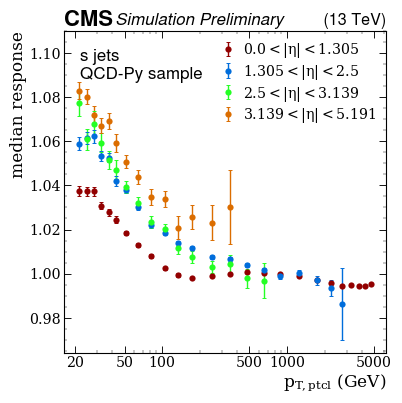

-------------------------
-------------------------
Fitting flavor:  q
Response fits won't be saved
N converge =  86 N_not_converge =  26
Figure saved: fig/corr_vs_pt/QCD-Py/corr_vs_pt_QCD-Py_q.pdf /.png


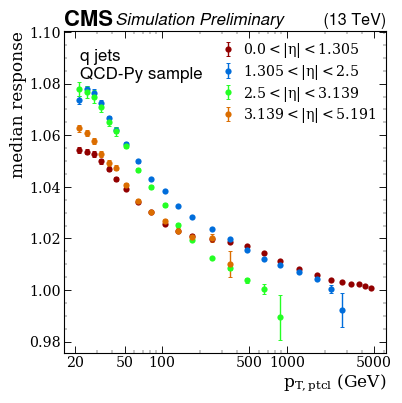

-------------------------
-------------------------
Fitting flavor:  u
Response fits won't be saved
N converge =  86 N_not_converge =  26
Figure saved: fig/corr_vs_pt/QCD-Py/corr_vs_pt_QCD-Py_u.pdf /.png


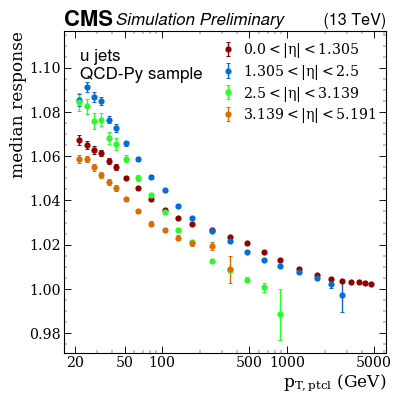

-------------------------
-------------------------
Fitting flavor:  d
Response fits won't be saved
N converge =  84 N_not_converge =  28
Figure saved: fig/corr_vs_pt/QCD-Py/corr_vs_pt_QCD-Py_d.pdf /.png


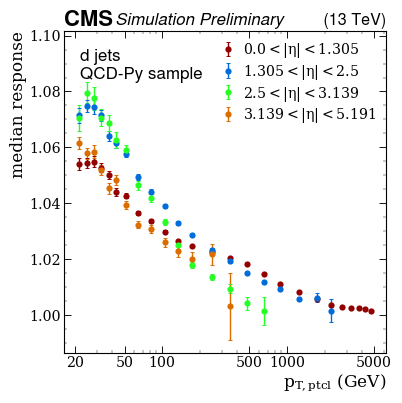

-------------------------
-------------------------
Fitting flavor:  unmatched
Response fits won't be saved
N converge =  66 N_not_converge =  46
Figure saved: fig/corr_vs_pt/QCD-Py/corr_vs_pt_QCD-Py_unmatched.pdf /.png


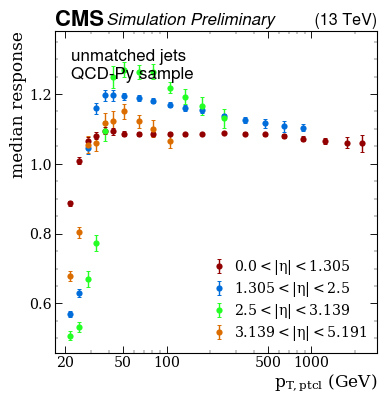

In [42]:
# %%time

medians = []
medianstds = []
combine_antiflavour = True
flavors = ['b', 'ud', 'all', 'g', 'c', 's', 'q', 'u', 'd', 'unmatched']
# flavors = ['q']
# flavors = ['all', 'all_minus_b', 'b' ,'all_unmatched', 'unmatched']
print('-'*25)
print('-'*25)
print(f'Starting to fit each flavor in: {flavors}')
for flav in flavors:
    print('-'*25)
    print('-'*25)
    print('Fitting flavor: ', flav)
    if load_fit_res:
        result = {}
        keys = ["Mean", "MeanVar", "Median", "MedianStd", "MeanRecoPt"] 
        for key in keys:
            result[key] = read_data(key, flav, tag_fit_res)
    
    else:
        result = fit_responses(hists_merged, flav, saveplots=False) #scaled_hist
        medians.append(result["Median"][0][0])
        medianstds.append(result["MedianStd"][0][0])
        for key in result:
            save_data(result[key], key, flav, tag_fit_res, pt_bins.centres, fiteta_bins.edges, out_txt_path)
            pass
            
#     print("result = ", result)
    median = result["Median"]
    medianStd = result["MedianStd"]
    
    meanstd = np.sqrt(result["MeanVar"])
            
    if eta_binning=="one_bin": #or fine_etabins:
        plot_corrections_eta(result["Median"], result["MedianStd"], pt_bins, fiteta_bins.centres, tag_fit_res, flav, plotptvals=[20, 35, 150, 400])
    else:
        plot_corrections(result["Median"], result["MedianStd"], pt_bins.centres, fiteta_bins, tag_fit_res, flav, plotetavals=[0, 1.305, 2.5, 3.139])
#         plot_corrections_eta(result["Median"], result["MedianStd"], pt_bins, fiteta_bins.centres, tag_fit_res, flav, plotptvals=[20, 35, 150, 400])

In [43]:
from helpers import find_result_file_index
log_file_name = "run_log.txt"

if not load_preexisting or load_fit_res:
    run_idx = find_result_file_index(log_file_name)
    file_name_title = f'Run_index_{run_idx}'
    # log_file = log_file_name.open('a')
    with open(log_file_name, 'a') as log_file:
        log_file.writelines(['\n' + file_name_title + '\nRun comment: ' + run_comment])
        log_file.writelines(['\n' + printout, '\nConfig parameters:\n' + str(processor_config)])

print('-----'*10)
print("All done. Congrats!")

--------------------------------------------------
All done. Congrats!


In [44]:
# from scipy.optimize import curve_fit
# def fit_response(xvals, yvals, Neff, Nfit=3, sigma_fit_window=1.5):
#     ''' fit response distribution with `Nfit` consecutive gaussian fits
#     Perform the second and further fits around the mean+/-<sigma_fit_window>*std of the previous fit.

#     '''
#     if_failed = False   #save if the fit failed or converged
    
#     # once adding weights, Neff appears to be ~1/4 - 1/3 of N when not using weights,
#     # so changing limits to match the both cases
#     if (np.sum(yvals)-Neff)/Neff<1e-5:
#         N_min_limit=50
#     else:
#         N_min_limit=15
    
#     nonzero_bins = np.sum(yvals>0)
#     if nonzero_bins<2 or Neff<N_min_limit:
#         p=[0,0,0]
#         chi2 = np.nan
#         cov = np.array([[np.nan]*3]*3)
#         Ndof = 0
#         if_failed = True
#     else:
#         try:
#             p, cov = curve_fit(gauss, xvals, yvals, p0=[10,1,1])
# #             print("p vals 0 = ", p)
#             ######## Second Gaussian ########
#             for i in range(Nfit-1):
#                 xfit_l, xfit_h = np.searchsorted(xvals,
#                                                  [p[1]-np.abs(p[2])*sigma_fit_window,
#                                                   p[1]+np.abs(p[2])*sigma_fit_window])
                
#                 # if there are only 3pnts, the uncertainty is infty
#                 # (or if too small, then the fit doesn't become good),
#                 # so increase the range
#                 rangeidx = 0
#                 while len(range(xfit_l,xfit_h))<6 and rangeidx<3:
#                     xfit_l = xfit_l-1
#                     xfit_h = xfit_h+1
#                     rangeidx+=1
#                 if xfit_l<0:
#                     xfit_h-=xfit_l
#                     xfit_l = 0
#                 xvals2 = xvals[xfit_l: xfit_h]
#                 yvals2 = yvals[xfit_l: xfit_h]
#                 p, cov = curve_fit(gauss, xvals2, yvals2, p0=p)
# #                 print(f"p vals {i+1} = ", p)
#                  ######## End second Gaussian ########

#             ygaus = gauss(xvals, *p)
#             chi2 = sum((yvals-ygaus)**2/(yvals+1E-9))
#             Ndof = len(xvals2)-3
#         except(RuntimeError):   #When fit failed
#             p=[0,0,0]
#             chi2 = np.nan
#             cov = np.array([[np.nan]*3]*3)
#             Ndof = 0
#             if_failed = True
            
#     return [p, cov, chi2, Ndof, if_failed]

In [45]:
# # flavor = 'g'
# response_hist_dict = {}
# for flavor in ['g', 'b', 'q']:
#     combine_antiflavour = True
#     response_hist, recopt_hist = add_flavors(output, flavor, combine_antiflavour)
    
#     response_hist = rebin_hist(response_hist, 'jeteta' , jeteta_bins.edges)
#     recopt_hist = rebin_hist(recopt_hist, 'jeteta' , jeteta_bins.edges)
    
#     if sum_neg_pos_eta_bool==True:
#         response_hist = sum_neg_pos_eta(response_hist)
#         recopt_hist = sum_neg_pos_eta(recopt_hist)
        
#     results = {key:np.zeros((pt_bins.nbins, fiteta_bins.nbins))
#                   for key in ["Mean", "MeanVar", "Median", "MedianStd", "MeanRecoPt"]  }
                            
#     N_converge = 0
#     N_not_converge = 0

#     xvals = response_hist.axes['ptresponse'].centers[1:] #[1:] to exclude the second peak for low pt
#     response_edges = response_hist.axes['ptresponse'].edges[1:]
#     response_hist_dict[flavor] = response_hist


# etaidx = 0
# pt_idx = 5
# histo_g = response_hist_dict['g'][pt_idx, :, etaidx]
# histo_b = response_hist_dict['b'][pt_idx, :, etaidx]
# histo_q = response_hist_dict['q'][pt_idx, :, etaidx]
# edd = histo_b.axes['ptresponse'].edges
# p = []
# for histo in [histo_b, histo_q, histo_g]:
#     histo = histo/histo.sum().value

#     yvals = histo.values()[1:len(edd)-2]     #[1:] to exclude the second peak for low pt
#     try:
#         Neff = histo.sum().value**2/(histo.sum().variance)
#     except ZeroDivisionError:
#         Neff = histo.sum().value**2/(histo.sum().variance+1e-11)

#     median, medianstd = get_median(xvals[:len(yvals)], yvals, response_edges, Neff)


#     ####################### Fitting ############################
#     p2, cov, chi2, Ndof, if_failed = fit_response(xvals[:len(yvals)], yvals, Neff)
#     p.append(p2)
    
# import mplhep as hep

# width_ik = np.abs(p2[2])
# f_xvals = np.linspace(0,max(xvals),5001)
# fgausb = gauss(f_xvals, *p[0])
# fgausq = gauss(f_xvals, *p[1])
# fgausg = gauss(f_xvals, *p[2])
# # edd = histo_q.axes['ptresponse'].edges
# histo_q = histo_q[1:len(edd)-2] 
# histo_g = histo_g[1:len(edd)-2] 
# histo_b = histo_b[1:len(edd)-2] 
# histo_q = histo_q/histo_q.sum().value
# histo_g = histo_g/histo_g.sum().value
# histo_b = histo_b/histo_b.sum().value

# fig, ax2 = plt.subplots();

# plot = histo_b.plot1d(ax=ax2, label='b jet', histtype='fill', alpha=0.6)
# plot = histo_q.plot1d(ax=ax2, label='usd jet', histtype='fill', alpha=0.6)
# ax2.plot(f_xvals, fgausb, label='Gaus, b jet', markersize=0, linewidth=1.8, color = '#920050')
# ax2.plot(f_xvals, fgausq, label='Gaus, usd jet', markersize=0, linewidth=1.8, color = '#3c1fdb')

# ax2.set_xlabel("Response ($p_{T,reco}/p_{T,ptcl}$)")
# max_lim = np.min([np.max(xvals), 2.0])
# ax2.set_xlim([0,max_lim])
# h = ax2.get_ylim()[1]/1.05

# hep.label.exp_text(text=f'$ {np.round(etabins_abs[etaidx],3)}<|\eta|<{np.round(etabins_abs[etaidx+1],3)}$, '+'$p_{T, ptcl}$'+f'$ = {ptbins_c[pt_idx]}$ GeV', loc=0)
# plt.show(); 